# Variational equations and asteroid (3666) Holman

Here we demonstrate the integration of (3666) Holman, a main belt asteroid, using ASSIST. We focus on the use of variational equations. This notebook assumes you're already somewhat familiar with ASSIST.  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import assist

We start by loading the ephemeris data. Depending on where you've downloaded them, you might need to change the paths.

In [6]:
ephem = assist.Ephem("../data/de440.bsp", "../data/sb441-n16.bsp")

Next, we setup a REBOUND simulation, add the initial position of asteroid Holman. The units are astronomical units for the positions and astronomical units per day for the velocities.

In [7]:
sim = rebound.Simulation()
holman_initial = rebound.Particle(
    x=3.338875348598862E+00, y=-9.176518412197102E-01, z=-5.038590741719294E-01, 
    vx=2.805663364339457E-03, vy=7.550408665778840E-03, vz=2.980028207875623E-03)
sim.add(holman_initial)

The following cell sets the initial simulation time. The above initial conditions are valid at 2458849.5 Julian Days (2020-Jan-01). In ASSIST, we measure time relative to the `jd_ref` parameter in the ephemeris structure.

In [8]:
sim.t = 2458849.5 - ephem.jd_ref

We also add two more particles to our simulations. One of them is a slightly perturbed initial condition of asteroid Holman, the other is a variational particle -- which will be explained further below.

In [9]:
holman_initial.x += 1e-8 # small perturbation in the x coordinate
sim.add(holman_initial)

In [10]:
var = sim.add_variation(testparticle=0)
var.particles[0].x = 1.0

Let's attach assist to the simulation.

In [11]:
ax = assist.Extras(sim, ephem)

We can now integrate the system forward in time for 10 thousand days, creating outputs every 20 days.

In [15]:
trange = 10_000
N = 500 # number of outputs
times = np.linspace(sim.t, sim.t+trange, N)

pos_holman = np.zeros((N,3))
pos_holman_per = np.zeros((N,3))
pos_holman_var = np.zeros((N,3))

for i in range(N):
    ax.integrate_or_interpolate(times[i])
    pos_holman[i] = sim.particles[0].xyz
    pos_holman_per[i] = sim.particles[1].xyz
    pos_holman_var[i] = var.particles[0].xyz

Let us plot the xyz values of the asteroid as a function of time. Note that the coordinate system is equatorial, so the z component is not nearly zero even though the asteroid has a small inclination.

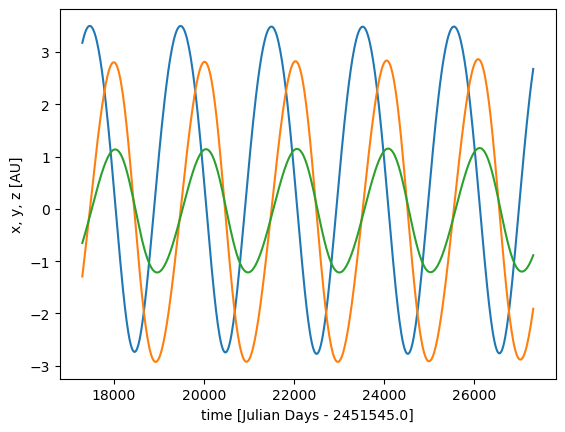

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel("time [Julian Days - %.1f]"%ephem.jd_ref)
ax.set_ylabel("x, y, z [AU]")
ax.plot(times, pos_holman);

The differences between the ASSIST-integrated positions and those from Horizons are ~3km after 10,000 days, respectively. 

Here is a top-down view of the orbit.

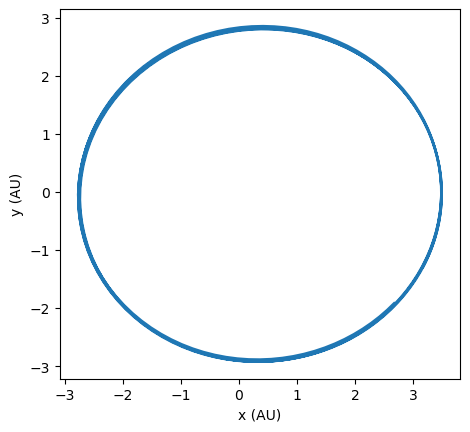

In [17]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
ax.plot(pos_holman[:,0], pos_holman[:,1]);

What about the variational particles in our simulation? These are vectors with the same dimensionality as an actual particle state, but they are the result of integrating the linearized tangent equations, or variational equations.  There is one variational particle for each of the six dimensions, with the initial state being a unit vector.

One way to think of the variational equations is to consider two states that are initially close to each other.  As we integrate both the two states will begin to separate.  We can imagine a vector pointing from one of the particles to the other.  (This is a vector is all six dimensions, both positions and velocities.) 

Suppose that instead of integrating the two particles we could integrate one of the particles and the vector from that particle to the other.  In addition to the equations of motion for the actual particle, we would need the equations of motion for the state vector between the two.  

That is what the linearized variational equations are, the equations of motion for the separation between two particles.  As "linearized" suggests, these equations are good to first order in the separation.  Also, the variational equations are associated with a big 6x6 matrix, with the terms of the matrix depending only upon the state of the actual particle.  The terms in the matrix are independent of the state vector describing the separation of the particles.  

The variational equations are the result of multiplying this big matrix by the state vector of the current separation.  That means we can multiply the same big matrix by any number of state vectors.   The big matrix is sparse (most of the elements are zero). So, the multiplication is not too expensive.  


The plot below shows the difference the x-components of two initially nearby trajectories, as well as the x-component of a corresponding 'variational particle' with the same displacement.  The two curves are offset by a small amount.  Otherwise the difference is not visible on this scale.  We can see the difference between the two approaches more clearly by subtracting one from the other.  They are, indeed, very close (note the mm scale).  The difference is due to the nonlinear terms that are not included in the variational equations.   The amplitude of difference is quadratic in time.  This is expect as the variational equations are valid to first order in the initial displacement.

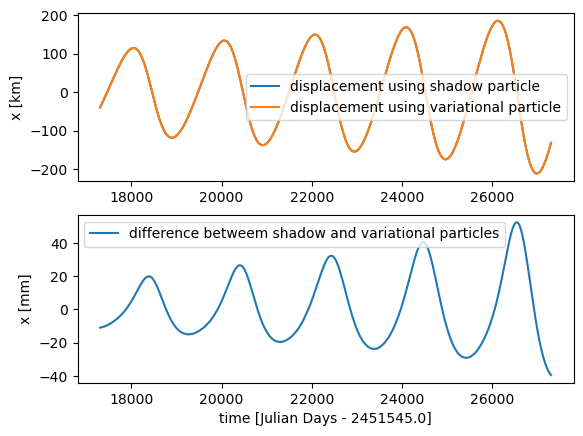

In [18]:
fig, ax = plt.subplots(2,1)
au_km = 149597870.700

ax[0].set_ylabel("x [km]")
ax[0].plot(times, (pos_holman_per[:,0]-pos_holman[:,0])*au_km, label='displacement using shadow particle')
ax[0].plot(times, (pos_holman_var[:,0]*1e-8)*au_km, label='displacement using variational particle')
ax[0].legend()

ax[1].set_xlabel("time [Julian Days - %.1f]"%ephem.jd_ref)
ax[1].set_ylabel("x [mm]")
ax[1].plot(times, ((pos_holman_per[:,0]-pos_holman[:,0])-pos_holman_var[:,0]*1e-8)*au_km*1e6, label='difference betweem shadow and variational particles')
ax[1].legend();